# 인물사진 모드 만들기

In [2]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [3]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/zico.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(509, 494, 3)


## 세그멘테이션(segmentation)
- 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션이라고 함.
- 모든 픽셀에 라벨을 할당하고 같은 라벨은 '공통적인 특징'을 가진다고 가정.
- 픽셀이 비슷하게 생겼다고 인식은 하지만 실제 물체 단위로 인식하지 않을 수 있음.

## 시멘틱 세그멘테이션
- 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션이라고 함.
- 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류하는 방법.

## 인스턴스 세그멘테이션
- 사람이라ㅣ는 추상적인 벙보를 이미지에서 추출해내는 방법.
- 사람이 누구인지 관계없이 같은 라벨로 표현됨.
- 사람 개개인별로 다른 라벨을 가지게 함.
- 여러 사람이 한 이미지에 등장할 때 객체를 분할해서 인식하는 것.

## 워터쉐드 세그멘테이션
- 이미지를 그레이스케일로 변환하여 픽셀 값을 각 위치의 높고 낮음으로 구분함.
- 낮은 부분부터 서서히 '물'을 채워 나간다 생각하면 각 영역에서 물이 차오르다가 넘치는 시점이 생김.
- 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됨.

## - 시맨틱 세그멘테이션 다뤄보기
- 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됨.
- 오늘은 DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력할 것.

### DeepLab Model

In [6]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    #__init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    #tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됨. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    #이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환.
    #모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, 
    #OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    #실제로 세그멘테이션을 하는 함수.
    def run(self, image):
        img_input = self.preprocess(image)

        #Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- 이번 노드에서는 구글에서 Tensorflow V1으로 작성한 DeepLab 모델 구조를 그대로 가져와 활용함.
- Tensorflow V2에서 V1 코드와 모델 구조를 활용할 수 있도록 제공하는 tf.compat.v1를 활용.
- 다소 생소할 수 있는 session, graph, feed_dict 등 Tensorflow V2에서는 Model, Input 등에 감추어져 있는 구조가 위 코드에 드러나 있음.

### 사전에 학습된 가중치 불러오기

In [7]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


- 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드하고 DeepLabModel 을 초기화 함.
- 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(509, 494, 3) (513, 497, 3) 16


- img_orig의 사이즈는 (509,494,3)이고 img_resized의 사이즈는 (513,497,3)
- cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시!
- 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 seg_map.max() 값이 출력 됨. (나는 16이 출력됨, 이는 사진에 따라 다르게 출력 됨)

### - DeepLab의 제공하는 PASCAL VOC 라벨 종류

In [11]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- background를 제외하면 20개의 클래스가 있음.
- 사진에 tv가 검출되지 않았다면 다른 숫자가 나올 것.

### 마스크를 만들고 시각화 하기
- 사람(person)에 해당하는 라벨, 즉 15를 가진 영역만 검출할 것

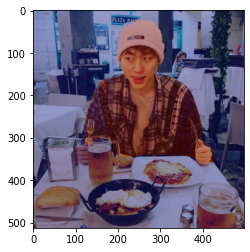

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) #예측 중 사람만 추출

#세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화.
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)

#applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 사람을 뜻하는 15 외 예측은 0으로 만들었기에 예측된 세그멘테이션 이미지(map)는 최댓값이 15가 됨.
- 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 함.

### 세그멘테이션 결과를 원래 크기로 복원하기
- 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법인 보간법(interpolation)을 사용.

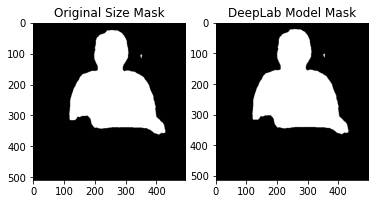

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

- 크기를 키울 때 보간(interpolation) 을 고려.
- cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용.
- 결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻음.
- 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정.
- 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법임.

### 배경 흐리게 만들기

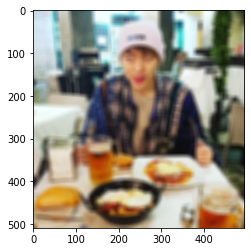

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻함. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐려진 이미지에 세그멘테이션 마스크를 이용해 배경만 추출

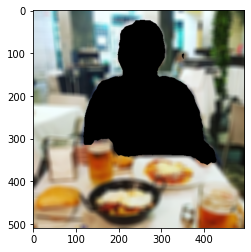

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)

#bitwise_not 함수를 이용하면 이미지가 반전됨.
#배경은 255, 사람은 0이 될 것.
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 영상 합성

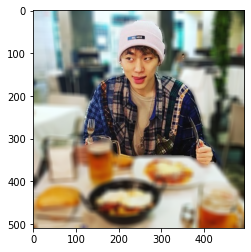

In [11]:
#세그멘테이션 마스크가 255인 부분만 원본 영상을 가져오고
#반대인 영역은 블러된 미지 값을 사용함.

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 합성

In [5]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat6.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(3023, 3015, 3)


In [9]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(3023, 3015, 3) (513, 511, 3) 8


In [12]:
print(LABEL_NAMES.index('cat'))

8


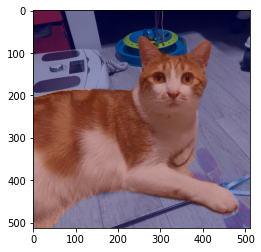

In [13]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) #cat 라벨만 추출

#세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화.
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)

#applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

(3015, 3023)


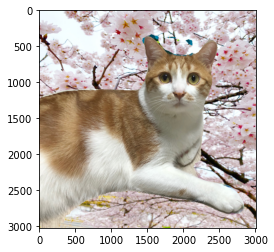

In [20]:
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg2.jpg'
bg_orig = cv2.imread(bg_path)
target_size = (img_orig.shape[1], img_orig.shape[0])
bg_resized = cv2.resize(bg_orig, target_size)
print(target_size)

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat = np.where(img_mask_color==255, img_orig, bg_resized)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()